<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/5_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Fixing seed

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup paths

In [6]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 2
MODELS_TRIAL = 2

Mounted at /content/gdrive


In [7]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_2 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2 already exists


# Download the data

In [8]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)

df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.995545,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.020451,0.693147
1,0.995545,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,0.0,1.0,0.138344,0.693147


In [9]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994059,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.071805,14.842280
1,0.993564,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,...,0.611695,0.655776,0.253599,0.511872,0.0,0.0,0.0,1.0,0.112946,15.312391


In [10]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994554,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,...,0.168216,0.655776,0.253599,1.094000,0.0,0.0,0.0,1.0,0.132383,15.278005
1,0.993564,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,1.0,0.0,1.0,0.0,0.365242,15.255171


In [11]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Define architecture

In [33]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


ffnn = Sequential(
    [
        layers.Input(shape=X_train_val.shape[1]),
        layers.Dense(units=10, activation='relu'),
        layers.Dense(units=10, activation='relu'),
        layers.Dense(units=1, activation='linear')
    ]
)

ffnn.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

pep8(_ih)

# Data treatment

In [23]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_sample_scaled = scaler.transform(X_test_sample)

In [24]:
np.max(X_train_val_scaled), np.max(X_train_val)

(1.0000000000000002, 6.313725890298421)

# Run training

In [34]:
from tensorflow.keras.callbacks import EarlyStopping


np.random.seed(RANDOM_SEED)

stopper = EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=10
)

history = ffnn.fit(
    X_train_val_scaled,
    Y_train_val,
    validation_data=(
        X_test_sample_scaled,
        Y_test_sample
    ),
    batch_size=16,
    epochs=500,
    callbacks=[stopper]
)

pep8(_ih)

Epoch 1/500
8/8 [==============================] - 0s 19ms/step - loss: 224.6500 - val_loss: 217.9234
Epoch 2/500
8/8 [==============================] - 0s 5ms/step - loss: 220.9972 - val_loss: 213.4716
Epoch 3/500
8/8 [==============================] - 0s 5ms/step - loss: 216.6369 - val_loss: 208.0625
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 211.6385 - val_loss: 201.2879
Epoch 5/500
8/8 [==============================] - 0s 5ms/step - loss: 205.2004 - val_loss: 193.5347
Epoch 6/500
8/8 [==============================] - 0s 5ms/step - loss: 197.3194 - val_loss: 184.2269
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 187.8901 - val_loss: 173.2811
Epoch 8/500
8/8 [==============================] - 0s 5ms/step - loss: 176.4717 - val_loss: 160.7988
Epoch 9/500
8/8 [==============================] - 0s 5ms/step - loss: 163.5483 - val_loss: 146.1921
Epoch 10/500
8/8 [==============================] - 0s 5ms/step - loss: 148.7839 - val_los

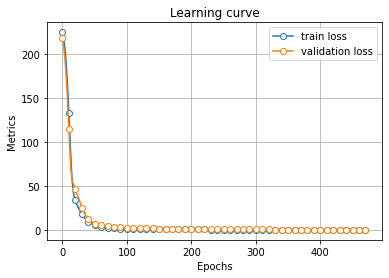

In [41]:
import matplotlib.pyplot as plt

def plot_ffnn_history(fit_history):
    _, ax = plt.subplots()
    
    plot_params = dict(
        marker='o',
        markevery=10,
        markerfacecolor='white'
    )

    ax.plot(
        history.history['loss'], 
        label='train loss',
        **plot_params
    )
    ax.plot(
        history.history['val_loss'], 
        label='validation loss',
        **plot_params
    )

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metrics')
    ax.set_title('Learning curve')

    ax.legend()
    ax.grid()

plot_ffnn_history(history)

# Save model

In [42]:
manager.save_models(
    {
        'FFNN': ffnn
    }
)